Patryk Zduńczak 
for Lion’s Den Credit risk modelling exercise 
ING Hubs Poland 
February 2023

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from matplotlib import pyplot as plt


## Getting familiar with the Data

In [49]:
credit_sample = pd.read_csv('credit_sample.csv')

In [50]:
credit_sample.columns.values

array(['ID', 'obs_date', 'Var_01', 'Var_02', 'Var_03', 'Var_04', 'Var_05',
       'Var_06', 'Var_07', 'Var_08', 'Var_09', 'Var_10', 'Var_11',
       'Var_12', 'Var_13', 'Var_14', 'Var_15', 'Var_16', 'Var_17',
       'Var_18', 'Var_19', 'Var_20', 'Var_21', 'Var_22', 'Var_23',
       'Var_24', 'Var_25', 'Var_26', 'Var_27', 'Var_28', 'Var_29',
       'Var_30', 'Var_31', 'Var_32', 'Var_33', 'Var_34', 'Var_35',
       'Var_36', 'Var_37', 'Var_38', 'Var_39', 'default'], dtype=object)

In [51]:
variables = pd.read_excel("description of variables.xlsx", engine='openpyxl', sheet_name="Sheet2")
variables_dict = dict(zip(variables.Column, variables.Description))

In [52]:
credit_sample.rename(columns=variables_dict,
          inplace=True)

In [53]:
credit_sample.rename(columns = {"target variable: 1 for a performing company defaulting within the next 12 months, 0 otherwise": "default"}, inplace=True)

In [54]:
credit_sample

,Customer ID,observation date when financial data are observed,Assets Current Total,Assets Total,Cash And Cash Equivalents,Current Ratio,Debt Net Worth,Depreciation And Impairment,EBITDA Margin,Earnings Before Interest And Tax,...,Sales Total Assets,Senior Net Debt,Senior Net Debt EBITDA,Tangible Net Worth,Total Liabilities Total Assets,Total Net Debt,Total Net Debt EBITDA,Trade And Other Payables Current,Working Capital,default
0,16680574,2015-03-31,1.113874e+07,1.376687e+07,5.088808e+04,1.381694,1.480514,7.173578e+05,0.080700,1.261532e+06,...,1.781196,4.413310e+06,1.830489,1.703930e+06,0.742622,6.391379e+06,3.229780,2.983519e+06,3.077087e+06,0
1,96135545,2015-12-31,3.162025e+10,5.264251e+10,1.191007e+10,1.349057,-0.240472,1.696850e+09,0.463526,2.699133e+10,...,1.175688,-1.129475e+10,-0.225773,2.569705e+10,0.488350,-1.129475e+10,-0.393707,2.825408e+09,8.181468e+09,1
2,96135545,2017-12-31,4.362366e+10,7.431924e+10,1.368830e+10,1.276777,-0.250091,2.310428e+09,0.466883,3.555459e+10,...,1.091261,-1.245830e+10,-0.238898,3.375606e+10,0.513312,-1.245830e+10,-0.329019,4.073381e+09,9.456634e+09,0
3,96135545,2021-12-31,7.415145e+10,1.685034e+11,1.514736e+10,0.860113,0.112167,5.219493e+09,0.459297,5.080364e+10,...,0.723878,7.935362e+09,0.122707,2.388838e+10,0.636282,7.935362e+09,0.141644,7.684133e+09,-1.205984e+10,0
4,96135545,2018-12-31,4.217623e+10,7.909355e+10,1.116617e+10,1.090521,-0.208307,2.802609e+09,0.457592,3.373699e+10,...,1.009588,-1.079843e+10,-0.211018,3.334141e+10,0.532008,-1.079843e+10,-0.295527,4.824058e+09,3.500941e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148924,50036390,2020-12-31,9.856401e+04,1.013964e+05,1.014642e+04,6.425659,0.362302,8.737854e+02,0.131924,6.657380e+04,...,5.042210,2.374815e+04,0.298407,5.555275e+04,0.452123,2.374815e+04,0.352098,4.125691e+03,8.322488e+04,0
148925,15853756,2017-12-31,3.476749e+04,4.989166e+04,2.676141e+04,1.279394,-2.894691,-3.668688e+01,0.215534,6.679014e+04,...,6.207698,-2.676141e+04,-0.334267,7.708415e+03,0.845497,-2.676141e+04,-0.400899,2.377143e+03,7.592517e+03,0
148926,15853756,2016-12-31,9.395386e+03,1.316894e+04,8.052164e+03,0.646936,0.367477,4.352037e+02,0.076480,2.009101e+04,...,20.380253,-8.052164e+03,-0.351285,-1.962178e+04,2.490004,-8.052164e+03,-0.392287,0.000000e+00,-5.127524e+03,0
148927,91988808,2021-06-30,7.853617e+04,3.431528e+06,1.570044e+04,1.323897,-120.526693,NaN,-0.014040,-1.590527e+03,...,0.033013,3.372337e+06,-1199.692943,-1.583171e+04,1.004614,3.372337e+06,-2120.263607,3.529997e+04,1.921420e+04,0


## Data Preparation

In [55]:
credit_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148929 entries, 0 to 148928
Data columns (total 42 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Customer ID                                        148929 non-null  int64  
 1   observation date when financial data are observed  148929 non-null  object 
 2   Assets Current Total                               148557 non-null  float64
 3   Assets Total                                       148929 non-null  float64
 4   Cash And Cash Equivalents                          144582 non-null  float64
 5   Current Ratio                                      147705 non-null  float64
 6   Debt Net Worth                                     147521 non-null  float64
 7   Depreciation And Impairment                        136644 non-null  float64
 8   EBITDA Margin                                      148929 non-null  float6

In [56]:
credit_sample.drop(columns=["observation date when financial data are observed"], axis=1, inplace=True)

In [57]:
credit_sample.dropna(axis=0,inplace=True)

In [58]:
credit_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108708 entries, 0 to 148924
Data columns (total 41 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Customer ID                                    108708 non-null  int64  
 1   Assets Current Total                           108708 non-null  float64
 2   Assets Total                                   108708 non-null  float64
 3   Cash And Cash Equivalents                      108708 non-null  float64
 4   Current Ratio                                  108708 non-null  float64
 5   Debt Net Worth                                 108708 non-null  float64
 6   Depreciation And Impairment                    108708 non-null  float64
 7   EBITDA Margin                                  108708 non-null  float64
 8   Earnings Before Interest And Tax               108708 non-null  float64
 9   Earnings Before Interest Tax And Depr

In [59]:
credit_sample["default"].value_counts()

0    102392
1      6316
Name: default, dtype: int64

Data set is not balanced. Would be nice to balance it.

In [60]:
credit_sample.describe()

,Customer ID,Assets Current Total,Assets Total,Cash And Cash Equivalents,Current Ratio,Debt Net Worth,Depreciation And Impairment,EBITDA Margin,Earnings Before Interest And Tax,Earnings Before Interest Tax And Depreciation,...,Sales Total Assets,Senior Net Debt,Senior Net Debt EBITDA,Tangible Net Worth,Total Liabilities Total Assets,Total Net Debt,Total Net Debt EBITDA,Trade And Other Payables Current,Working Capital,default
count,1.087080e+05,1.087080e+05,1.087080e+05,1.087080e+05,1.087080e+05,1.087080e+05,1.087080e+05,108708.000000,1.087080e+05,1.087080e+05,...,1.087080e+05,1.087080e+05,108708.000000,1.087080e+05,108708.000000,1.087080e+05,108708.000000,1.087080e+05,1.087080e+05,108708.000000
mean,5.031037e+07,6.660115e+10,2.140274e+11,1.829320e+10,2.628020e+02,1.006562e+03,7.836198e+09,-2.522973,1.009651e+10,1.793271e+10,...,2.064082e+00,4.558091e+10,-0.649381,9.467648e+10,0.705611,4.598324e+10,-0.805733,1.629769e+10,1.585031e+10,0.058101
std,2.898023e+07,2.113427e+12,8.769955e+12,6.478686e+11,8.576609e+04,2.879638e+05,2.618890e+11,852.435049,3.527199e+11,5.939641e+11,...,5.980863e+01,2.162083e+12,2080.745991,4.998654e+12,35.666977,2.163768e+12,3279.046199,4.025975e+11,8.771466e+11,0.233935
min,1.574000e+03,-4.004716e+05,8.711449e+02,-1.699122e+09,-2.854679e+03,-1.946031e+06,-1.907482e+10,-280937.000000,-9.215122e+12,-6.222005e+12,...,1.039606e-09,-6.700936e+13,-607028.821861,-3.816045e+12,-0.834463,-6.700936e+13,-984219.792959,-6.364053e+07,-5.150561e+13,0.000000
25%,2.520319e+07,6.038366e+05,1.724332e+06,5.929236e+04,1.008270e+00,-1.189502e-02,4.481262e+04,0.054301,8.944163e+04,1.760077e+05,...,5.947352e-01,-1.536419e+04,-0.093033,2.969271e+05,0.451388,-1.305424e+04,-0.124178,8.473784e+04,4.314129e+03,0.000000
50%,5.064553e+07,5.652242e+06,1.313725e+07,5.209228e+05,1.407579e+00,3.295131e-01,3.317694e+05,0.116025,4.631345e+05,1.005484e+06,...,1.245874e+00,9.378535e+05,0.884568,2.321538e+06,0.615714,9.758895e+05,1.339625,9.929391e+05,4.519824e+05,0.000000
75%,7.547071e+07,2.089498e+08,5.862263e+08,2.367772e+07,2.178205e+00,9.476910e-01,1.427821e+07,0.230697,1.729185e+07,3.780295e+07,...,2.189490e+00,5.906253e+07,2.632732,8.435876e+07,0.757917,6.081142e+07,3.864334,4.754809e+07,1.631342e+07,0.000000
max,9.999212e+07,3.327554e+14,1.405818e+15,8.034265e+13,2.827785e+07,9.480086e+07,3.520633e+13,4281.701992,3.929023e+13,7.392226e+13,...,1.779000e+04,3.525187e+14,273740.281929,8.339219e+14,11759.405302,3.525187e+14,374408.632603,4.587739e+13,1.379385e+14,1.000000


Balancing set - Oversampling

In [61]:
# class count
class_count_0, class_count_1 = credit_sample['default'].value_counts()

# Separate class
class_0 = credit_sample[credit_sample['default'] == 0]
class_1 = credit_sample[credit_sample['default'] == 1]
#print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (102392, 41)
class 1: (6316, 41)


total class of 1 and 0: 1    102392
0    102392
Name: default, dtype: int64


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

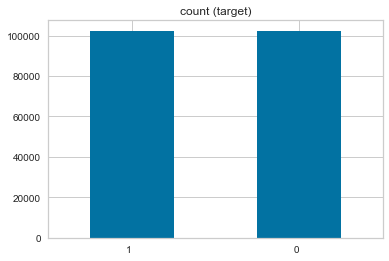

In [62]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_over['default'].value_counts())# plot the count after under-sampeling
test_over['default'].value_counts().plot(kind='bar', title='count (target)')
plt.xticks(rotation=0, ha='right')

In [63]:
df_over = test_over

## Looking for a best model

In [64]:
#split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df_over.loc[:, df_over.columns != 'default'], df_over['default'], test_size=0.3)

# print the training data and target
print("Training data:")
print(X_train)
print("\nTraining target:")
print(Y_train)

# print the test data and target
print("\nTest data:")
print(X_test)
print("\nTest target:")
print(Y_test)

Training data:
        Customer ID  Assets Current Total  Assets Total  \
84791      81062514          1.176177e+13  1.942686e+13   
25484      86089116          5.872355e+04  2.285524e+06   
50142       9414048          7.613612e+07  3.093227e+09   
249        92640533          1.374698e+11  3.431679e+11   
51628      20936798          1.151210e+06  3.805191e+06   
...             ...                   ...           ...   
129544     54685456          2.470487e+08  2.742066e+09   
62976      33262351          1.975473e+08  1.759774e+09   
10007      78039995          1.529919e+07  1.822697e+07   
97717      61045058          5.522770e+05  7.813059e+05   
117821     79515455          2.350826e+09  3.084185e+09   

        Cash And Cash Equivalents  Current Ratio  Debt Net Worth  \
84791                5.876231e+12       1.621283       -0.398099   
25484                9.963443e+03       0.197728        1.101077   
50142                1.612279e+07       0.466898        1.961869   
249 

Logistic Regression

In [65]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, Y_train)  # apply scaling on training data

lr_score = pipe_lr.score(X_test, Y_test)  # apply scaling on testing data
lr_score

/Users/patryk/opt/anaconda3/envs/MF/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6040432319812488

Random Forest

In [66]:
pipe_rfc = make_pipeline(StandardScaler(),  RandomForestClassifier())
pipe_rfc.fit(X_train, Y_train)  # apply scaling on training data

rf_score = pipe_rfc.score(X_test, Y_test)  # apply scaling on testing data
rf_score

0.9888501855589557

In [67]:
pipe_rfc.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 

XGBoost

In [68]:
pipe = make_pipeline(StandardScaler(),  xgb.XGBClassifier())
pipe.fit(X_train, Y_train)  # apply scaling on training data

xgb_score = pipe.score(X_test, Y_test)  # apply scaling on testing data
xgb_score

0.8984471645289407

In [69]:
pd.DataFrame(data = {'classificator': ['LogisticRegression','RandomForestClassifier', "XGBoost"], 'score': [lr_score, rf_score, xgb_score]}, columns = ["classificator", "score"]).sort_values(by='score', ascending=False)

,classificator,score
1,RandomForestClassifier,0.988850
2,XGBoost,0.898447
0,LogisticRegression,0.604043


## Getting insights of the best model

Feature importances

In [93]:
for col, val in sorted(
    zip(
    X_train.columns,
    pipe_rfc.named_steps['randomforestclassifier'].feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True
)[:5]:
    if col in ["Working Capital", "Gross Profit"]:
        print(f"{col:10}\t\t{val:10.3f}")
    elif col == 'IFRS_Assets Current Total':
        print(f"{col:10}{val:10.3f}")
    else:
        print(f"{col:10}\t{val:10.3f}")


Working Capital		     0.093
Gross Profit		     0.054
IFRS_Assets Current Total     0.048
Sales Excluding VAT	     0.041
Assets Current Total	     0.041


Confusion Matrix

In [71]:
y_pred = pipe_rfc.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
cm

array([[29984,   685],
       [    0, 30767]])

/Users/patryk/opt/anaconda3/envs/MF/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


[Text(0.5, 1.0, 'Confusion matrix: Random Forest Classificator'),
 Text(0.5, 0, 'Forecast Class'),
 Text(0, 0.5, 'Real Class')]

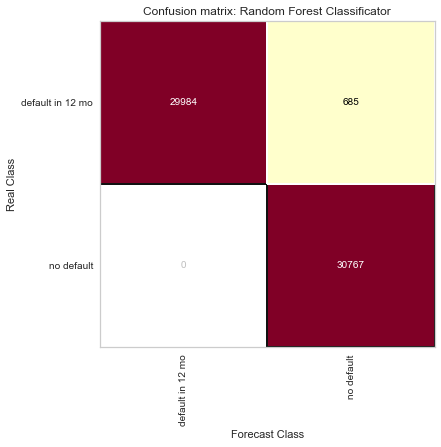

In [76]:
mapping= ["default in 12 mo", "no default"]
fig, ax = plt.subplots(figsize=(6,6))
cm_viz = ConfusionMatrix(
    pipe_rfc,
    classes = ["default in 12 mo", "no default"],
    label_encoder = mapping,
)

cm_viz.score(X_test, Y_test)

cm_viz.ax.set(title="Confusion matrix: Random Forest Classificator",
              xlabel = "Forecast Class",
              ylabel = "Real Class")

In [73]:
# Generate the classification report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     30669
           1       0.98      1.00      0.99     30767

    accuracy                           0.99     61436
   macro avg       0.99      0.99      0.99     61436
weighted avg       0.99      0.99      0.99     61436



ROC

/Users/patryk/opt/anaconda3/envs/MF/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


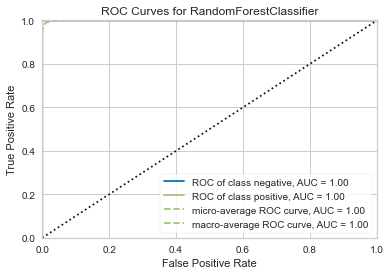

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
visualizer = ROCAUC(pipe_rfc, classes=["negative", "positive"])

# Fit the visualizer and generate the ROC AUC curve
visualizer.fit(X_train, Y_train)
visualizer.score(X_test, Y_test)

# Show the plot
visualizer.show()

In [75]:
visualizer.score(X_test, Y_test)

0.9999999711057883